In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Literal
from langchain_core.messages import HumanMessage, AIMessage

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from IPython.display import Image, display
import gradio as gr
import torch,json

from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from typing import Literal, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import BaseMessage, AIMessage

/home/joshua/miniconda3/envs/llm-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DUMMY DATA

In [3]:
dummy_path = r"/home/joshua/llms/IFB398/dummy_data.json"
with open("chat_flow.json") as f:
    chat_flow = json.load(f)

# MODEL SETUP

In [4]:
model_path = "/mnt/models/llm_storage/Llama-3.2-3B-Instruct"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_path)

model = AutoModelForCausalLM.from_pretrained(
    model_path, 
    torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
    device_map="cuda:0"
)

template = """You are collecting business profile information.
Ask the user for:
- business name
- core capabilities
- the industry they operate in
- business goals

Only call the tool when you are confident all required information has been gathered."""

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


# NODES

In [5]:
class UserProfile(BaseModel):
    business_name: str
    capabilities: list[str]
    industry: str
    goals: str

class State(TypedDict):
    messages: Annotated[list, add_messages]
    answers: dict[str, str]

In [6]:
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import BaseMessage, AIMessage
import torch

class LocalLlamaChat(BaseChatModel):
    def __init__(self, model, tokenizer, max_new_tokens=300):
        super().__init__()  # avoid BaseModel init conflict
        object.__setattr__(self, "model", model)
        object.__setattr__(self, "tokenizer", tokenizer)
        object.__setattr__(self, "max_new_tokens", max_new_tokens)

    def _format_prompt(self, messages: list[BaseMessage]) -> str:
        prompt = ""
        for msg in messages:
            if msg.type == "system":
                prompt += f"<|system|>\n{msg.content}\n"
            elif msg.type == "human":
                prompt += f"<|user|>\n{msg.content}\n"
            elif msg.type == "ai":
                prompt += f"<|assistant|>\n{msg.content}\n"
        prompt += "<|assistant|>\n"
        return prompt

    def invoke(self, messages: list[BaseMessage], **kwargs) -> AIMessage:
        prompt = self._format_prompt(messages)
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=self.max_new_tokens,
                do_sample=True,
                temperature=0.7,
                top_p=0.95
            )

        response_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        completion = response_text.split("<|assistant|>\n")[-1].strip()
        return AIMessage(content=completion)

    @property
    def _llm_type(self) -> str:
        return "local-llama"

    def _generate(self, messages: list[BaseMessage], **kwargs):
        raise NotImplementedError("Use invoke() instead")

    
local_llm = LocalLlamaChat(model=model, tokenizer=tokenizer)

In [7]:
with open("chat_flow.json") as f:
    chat_flow = json.load(f)

def check_relevance(user_input: str, expected_question: str) -> bool:
    system_prompt = (
        "You are an assistant that checks whether a user's response is relevant to a given question.\n"
        f"Question: {expected_question}\n"
        f"User Input: {user_input}\n"
        "Answer only with 'Yes' if it answers the question, or 'No' if it is off-topic."
    )
    resp = local_llm.invoke([SystemMessage(content=system_prompt)])
    return "yes" in resp.content.lower()


def info_node(state: State) -> State:
    messages = state["messages"]
    answers = state.get("answers", {})
    num_answered = len(answers)

    if num_answered >= len(chat_flow):
        return {
            "messages": [AIMessage(content="Thanks! I have all the info I need.")],
            "answers": answers,
        }

    current_question = chat_flow[num_answered]
    current_question_id = current_question["id"]
    current_question_prompt = current_question["prompt"]

    # If latest message is from user, check if it's relevant
    if messages and isinstance(messages[-1], HumanMessage):
        user_input = messages[-1].content.strip()
        if check_relevance(user_input, current_question_prompt):
            answers[current_question_id] = user_input
            num_answered += 1

            # If this was the final question
            if num_answered >= len(chat_flow):
                return {
                    "messages": [AIMessage(content="Thanks! I have all the info I need.")],
                    "answers": answers,
                }
            # Move on to next question
            current_question = chat_flow[num_answered]
            current_question_prompt = current_question["prompt"]
        else:
            # Respond to off-topic input, then re-ask the same question
            polite_response = f"Thanks for that! But just to stay on track, {current_question_prompt}"
            return {
                "messages": [AIMessage(content=polite_response)],
                "answers": answers,
            }

    # Proceed with next question
    guidance = "\n".join([f"- {q['prompt']} (should {q['validation_hint']})" for q in chat_flow])
    system_instruction = (
        "You are collecting business profile information. You must ask questions in order.\n"
        f"{guidance}\n"
    )
    prompt_messages = [SystemMessage(content=system_instruction)] + messages

    ai_response = local_llm.invoke(prompt_messages)
    if current_question_prompt not in ai_response.content:
        ai_response.content += f"\n\n{current_question_prompt}"

    return {
        "messages": [ai_response],
        "answers": answers,
    }



In [8]:
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="All user profile info gathered.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

In [9]:
def get_prompt_messages(messages):
    tool_call = None
    after_tool_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            after_tool_msgs.append(m)
    system = f"Based on the business info below, provide a summary and partner suggestions.\n\nBusiness Info:\n{tool_call}"  # make more detailed later
    return [SystemMessage(content=system)] + after_tool_msgs

In [10]:
def generate_prompt(state: State):
    answers = state.get("answers", {})
    summary = (
        f"Business Name: {answers.get('name', '')}\n"
        f"Company: {answers.get('company', '')}\n"
        f"Products/Services: {answers.get('products', '')}\n"
        "\nBased on the above, create a personalized strategy including ideal partners, market suggestions, and next steps."
    )
    response = local_llm.invoke([
        SystemMessage(content=summary)
    ])
    return {"messages": [response]}


# ROUTER

In [11]:
def get_state(state: State) -> Literal["info", "add_tool_message", "generate", END]:
    if isinstance(state["messages"][-1], AIMessage) and state["messages"][-1].tool_calls:
        return "add_tool_message"
    elif "answers" in state and len(state["answers"]) == len(chat_flow):
        return "generate"
    return "info"

# BUILDING

In [12]:
memory = MemorySaver()
graph = StateGraph(State)
graph.add_node("info", info_node)
graph.add_node("add_tool_message", add_tool_message)
graph.add_node("generate", generate_prompt)
graph.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
graph.add_edge("add_tool_message", "generate")
graph.add_edge("generate", END)
graph.set_entry_point("info")

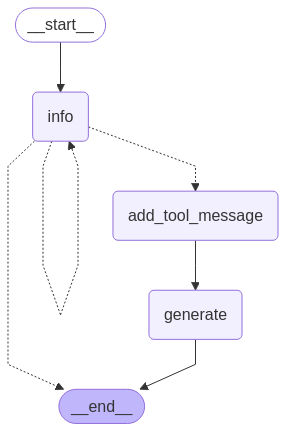

In [13]:
graph = graph.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

# RUNNING

In [ ]:
import uuid
def interactive_chat(user_input: str) -> str:
    global chat_state, chat_config

    # Reset state if needed
    if user_input.strip().lower() in {"reset"}:
        chat_state = {"messages": []}
        chat_config = {"configurable": {"thread_id": str(uuid.uuid4())}}
        return "Session reset. Please type START to begin."

    chat_state["messages"].append(HumanMessage(content=user_input))

    response = ""
    for output in graph.stream(chat_state, config=chat_config, stream_mode="updates"):
        last_msg = next(iter(output.values()))["messages"][-1]
        response = last_msg.content  # store latest response

    return response

chat_state = {"messages": []}
chat_config = {"configurable": {"thread_id": str(uuid.uuid4())}}

gr.Interface(
    fn=interactive_chat,
    inputs=gr.Textbox(lines=2, placeholder="Type 'START' to begin"),
    outputs="text",
    title="SMARTConnect V2 - Business Partnership Finder",
    description="Say 'START' to begin the business discovery process. Type 'RESET' anytime to restart."
).launch(server_name="0.0.0.0", server_port=7862, share=True)

Running on local URL:  http://0.0.0.0:7862


/home/joshua/miniconda3/envs/llm-env/lib/python3.10/site-packages/gradio/analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.37.2, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


Running on public URL: https://a512c36b8124d30948.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

: 